*** Cephalometric Keypoints 'from-scratch' CNN Run*** <br>

Wang ceph dataset link: https://figshare.com/s/37ec464af8e81ae6ebbf <br>
x - got it up to 2000 train and 500ish test (5 perturbations + original per 300 images) <br>
try next: more preprocessing (would contrast enhancement e.g. histogram equalization help?) <br>
also next (sep notebook maybe): resnet-18 fine-tune on larger 224x224 image size <br>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import time
import random

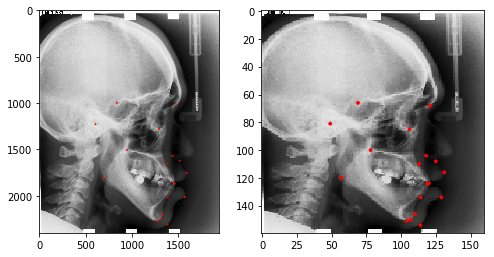

In [9]:
# Take a look at one of the image samples and labels
SAMPLE_PATH = "ceph_test_data/001.bmp"
TXT_PATH = "ceph_test_data/001.txt"
# import sample image
img = io.imread(SAMPLE_PATH, as_grey=True)
# import sample coordinates from csv as tuples
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:18]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

coords_raw = extract_labels_from_txt(TXT_PATH)

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)
ax1.imshow(img, cmap="gray")
# also plot resized image for later 
orig_y, orig_x = img.shape[:2]
SCALE = 15

# for rescale, use same target for both x&y axis
rescaled_img = transform.resize(img,(orig_y/SCALE,orig_y/SCALE))
ax2.imshow(rescaled_img, cmap="gray")

for c in coords_raw:
    # add patches to original image
    # could also just plt.scatter() but less control then
    ax1.add_patch(plt.Circle(c, 5, color='r')) 
    # and rescaled marks to resized images
    x,y = c
    x = int(x*(orig_y*1.0/orig_x)/SCALE)
    y = int(y/SCALE)
    ax2.add_patch(plt.Circle((x,y), 1, color='r')) 

plt.show()

In [10]:
# Network definition
# (((I0−k0+1)/M0)−k1+1)/M1)  
# ((((160−5+1)/2)−3+1)/2)-3+1)/2 = 18 <br>
# CNN Model (3 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(24, 36, kernel_size=3),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(18*18*48, 18*18*48),
            nn.BatchNorm1d(18*18*48),
            nn.ReLU(),
            nn.Linear(18*18*48, 18*48),
            nn.BatchNorm1d(18*48),
            nn.ReLU(),
            nn.Linear(18*48, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

# deeper CNN Model (4 conv layer)
# ((((((160−3+1)/2)-4+1)/2)-3+1)/2-3+1)/2 = 8
# declare from scratch rather than inherit
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(24, 36, kernel_size=4),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(48, 72, kernel_size=3),
            nn.BatchNorm2d(72),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*72, 8*8*72),
            nn.BatchNorm1d(8*8*72),
            nn.ReLU(),
            nn.Linear(8*8*72, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 


In [11]:
# Hyperparams
num_epochs = 5
batch_size = 10
learning_rate = 0.001

def optimizer(test_net, train_loader, num_epochs):
    start_time = time.time()
    epoch_data = []
    loss_data = []
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(test_net.parameters(), lr=learning_rate)
    # Train the Model
    for epoch in range(num_epochs):
        epoch_time = time.time()
        for i, (data, target) in enumerate(train_loader):
            vd = Variable(data)
            td = Variable(target)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = test_net(vd)
            loss = criterion(outputs, td)
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                # for plotting, append epoch and loss data to timeseries:
                epoch_data.append(epoch+1+(i+1)/10.0) # epochs as 1, 1.5, 2.0 etc
                loss_data.append(loss.data[0])
                # print updates:
                print "Epoch [{}/{}], Iter [{}/{}] Loss: {}, CPU seconds: {}".format(epoch+1, num_epochs, i+1, 
                                                    len(train)//batch_size, loss.data[0], time.time()-epoch_time)
    print("total time elapsed: {}".format(time.time()-start_time))
    plt.plot(epoch_data, loss_data)
    plt.ylabel('loss over time')
    plt.xlabel('training epoch')
    plt.show()

In [6]:
BASE_AUG_PATH = "/Users/franzr/Desktop/Dent_PJ_Stuff/dl_progression/aug_img/"
def prep_train_loader(img_path):
    data = []
    target = []
    for i, fi in enumerate(os.listdir(img_path)):
        if fi.endswith(".png"):
            loop_img = io.imread(img_path + fi, as_gray=True)
            lf = fi[:-4] + ".txt"
            loop_labels = extract_labels_from_txt(img_path + lf)
            loop_labels = (np.array(loop_labels) - 80.0)/80.0
            data.append(torch.from_numpy(loop_img).float())
            target.append(torch.from_numpy(loop_labels).float())
    data = torch.from_numpy(np.stack(data))
    data = torch.unsqueeze(data, 1)
    target = torch.stack(target)

    td = TensorDataset(data, target)
    tl = DataLoader(td, batch_size=10, shuffle=False)
    return td, tl

train, train_loader = prep_train_loader(BASE_AUG_PATH)

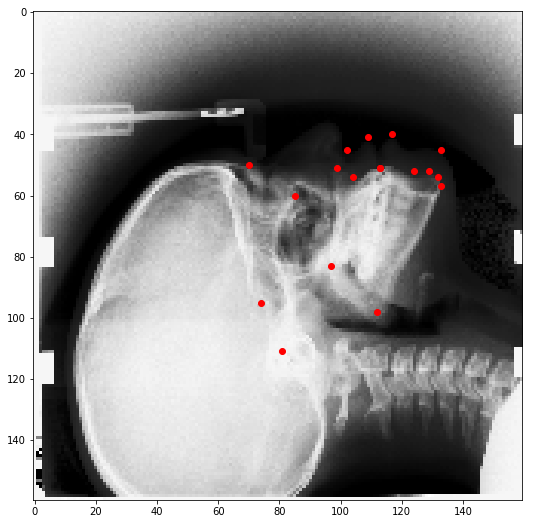

In [7]:
# (optional: make sure image data made it through torchisation intact:)
def plot_sample_tensor(dataset, n):
    sample = dataset[n][0].squeeze()
    sample_labels = dataset[n][1]
    sample_labels = sample_labels * 80 + 80
    sample_labels = [tuple(x) for x in sample_labels]
    plt.imshow(sample, cmap="gray")
    plt.scatter(*zip(*sample_labels), color="r")
    plt.show()
# plot a random image from tensor input:
plot_sample_tensor(train, random.randint(0, len(train)))

In [7]:
# Hyperparams
num_epochs = 5
batch_size = 10
learning_rate = 0.0005

cnn = CNN()
# deeper_cnn = DeeperCNN()
cnn.load_state_dict(torch.load("aug_model_attempt.pth.tar"))
optimizer(cnn, train_loader, num_epochs)
# optional save 
# torch.save(cnn.state_dict(), "aug_model_attempt.pth.tar")

In [24]:
# load in test set
TEST_AUG_BASE_PATH = "aug_img/TEST_SET/"
test_set, test_set_loader = prep_train_loader(TEST_AUG_BASE_PATH)

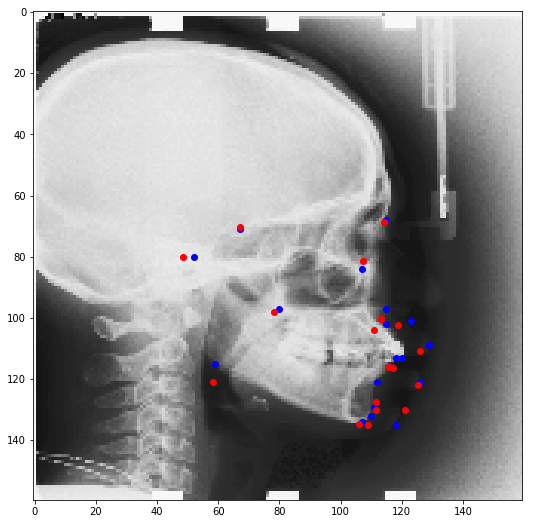

In [40]:
# test cnn on some images from test set (change i or use random to swap views)
for i, (data, target) in enumerate(test_set_loader):
    if i == 12:
        test_batch = Variable(data)
        test_target = Variable(target)

test_target = test_target[0].data.numpy()*80+80
test_target = test_target.tolist()

def group(lst, n):
    # group list into consec tuples
    return zip(*[lst[i::n] for i in range(n)]) 


test_img = test_batch[0].data.numpy().squeeze()
prediction = cnn(test_batch)[0].data.numpy()*80+80
prediction = group(prediction, 2)

plt.imshow(test_img, cmap="gray")
plt.scatter(*zip(*test_target[:]), color="blue")
plt.scatter(*zip(*prediction[:]), color="red")
plt.show()

...starting to look better, rotated images seem okay too. Some points (sella turcica, naseon) much easier than others - maybe poor contrast on soft tissues.